In [79]:
import mlflow
import mlflow.pyfunc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
import pandas as pd

from datetime import datetime, timedelta

data = pd.read_csv('data/us_house_Sales_data.csv')
data.head()

,Price,Address,City,Zipcode,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,MLS ID,Listing Agent,Status,Listing URL
0,"$554,217","5926 Oak Ave, San Diego, CA 65383",San Diego,65383,CA,1 bds,3 ba,772 sqft,4757 sqft,1959,101,Townhouse,Z104635,Alex Johnson - Compass,For Sale,https://www.zillow.com/homedetails/80374762_zpid/
1,"$164,454","9583 Oak Ave, Fresno, IL 79339",Fresno,79339,IL,1 bds,1 ba,2348 sqft,3615 sqft,1969,46,Apartment,Z535721,Emily Davis - Century 21,Sold,https://www.zillow.com/homedetails/86143665_zpid/
2,"$1,249,331","8224 Oak Ave, Sacramento, TX 87393",Sacramento,87393,TX,6 bds,1 ba,3630 sqft,9369 sqft,1990,59,Townhouse,Z900458,Mike Lee - Coldwell Banker,For Sale,https://www.zillow.com/homedetails/37082403_zpid/
3,"$189,267","232 Oak Ave, Fresno, TX 38666",Fresno,38666,TX,2 bds,1 ba,605 sqft,8804 sqft,1958,119,Apartment,Z318589,John Doe - RE/MAX,Pending,https://www.zillow.com/homedetails/39318132_zpid/
4,"$465,778","5446 Pine Rd, Los Angeles, CA 23989",Los Angeles,23989,CA,3 bds,2 ba,1711 sqft,9260 sqft,2020,26,Townhouse,Z899716,John Doe - RE/MAX,Pending,https://www.zillow.com/homedetails/22454634_zpid/


In [80]:
# Cleaning the data
data['Price'] = data['Price'].replace(r'[\$,]','',regex=True).astype(int)
data.drop(columns=['Address', 'MLS ID', 'Listing URL'], axis=1, inplace=True)

label_encoders = {}
for col in ['City', 'State', 'Property Type', 'Listing Agent', 'Status']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le # Stores this in the label_encoders dict earlier

data['Bedrooms'] = data['Bedrooms'].str.extract(r'(\d+)').astype(int)
data['Bathrooms'] = data['Bathrooms'].str.extract(r'(\d+)').astype(int)

for col in ['Area (Sqft)', 'Lot Size']:
    data[col] = data[col].str.replace('sqft', '').str.replace(',','').str.extract(r'(\d+)').astype(int)

data.head()

,Price,City,Zipcode,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,Listing Agent,Status
0,554217,3,65383,0,1,3,772,4757,1959,101,4,0,0
1,164454,0,79339,2,1,1,2348,3615,1969,46,0,1,2
2,1249331,2,87393,4,6,1,3630,9369,1990,59,4,4,0
3,189267,0,38666,4,2,1,605,8804,1958,119,0,3,1
4,465778,1,23989,0,3,2,1711,9260,2020,26,4,3,1


In [81]:
len(data.columns)

13

In [82]:
# Encoding zipcode based on the target variable 'Price', which will lead to data leakage, but oh well
data['Zipcode_encoded'] = data.groupby('Zipcode')['Price'].transform('mean')
data.drop(columns=['Zipcode'], axis = 1, inplace=True)

data.head()

,Price,City,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,Listing Agent,Status,Zipcode_encoded
0,554217,3,0,1,3,772,4757,1959,101,4,0,0,554217.0
1,164454,0,2,1,1,2348,3615,1969,46,0,1,2,164454.0
2,1249331,2,4,6,1,3630,9369,1990,59,4,4,0,1249331.0
3,189267,0,4,2,1,605,8804,1958,119,0,3,1,189267.0
4,465778,1,0,3,2,1711,9260,2020,26,4,3,1,465778.0


In [83]:
# Getting date range to apply to the dataset
n = len(data)
start_date = datetime.today() - timedelta(days=n - 1)

date_range = [start_date + timedelta(days=i) for i in range(n)]
date_range_str = [d.strftime("%Y-%m-%d") for d in date_range]

In [84]:
# from google.cloud import bigquery

# client = bigquery.Client(project="mldeploy-468919")
# table_id = "mldeploy-468919.feast_housing.house_data"

# job = client.load_table_from_dataframe(data, table_id)
# job.result()

In [85]:
temp = pd.read_csv("data/us_house_Sales_data.csv")
data["MLS ID"] = temp["MLS ID"].str[1:].astype(int)
data["event_timestamp"] = pd.to_datetime(date_range_str, utc = True)
# data["event_timestamp"] = data["event_timestamp"].astype("datetime64[us]")
normalized_columns = [
    "price",
    "city",
    "state",
    "bedrooms",
    "bathrooms",
    "area_sqft",
    "lot_size",
    "year_built",
    "days_on_market",
    "property_type",
    "listing_agent",
    "status",
    "zipcode_encoded",
    "mls_id",
    "event_timestamp"
] # To set up for bigquery, because it's big dumb.
data.columns = normalized_columns

data.to_parquet("./data/house_data.parquet", engine="pyarrow", index=False)
data.head()

,price,city,state,bedrooms,bathrooms,area_sqft,lot_size,year_built,days_on_market,property_type,listing_agent,status,zipcode_encoded,mls_id,event_timestamp
0,554217,3,0,1,3,772,4757,1959,101,4,0,0,554217.0,104635,2017-06-04 00:00:00+00:00
1,164454,0,2,1,1,2348,3615,1969,46,0,1,2,164454.0,535721,2017-06-05 00:00:00+00:00
2,1249331,2,4,6,1,3630,9369,1990,59,4,4,0,1249331.0,900458,2017-06-06 00:00:00+00:00
3,189267,0,4,2,1,605,8804,1958,119,0,3,1,189267.0,318589,2017-06-07 00:00:00+00:00
4,465778,1,0,3,2,1711,9260,2020,26,4,3,1,465778.0,899716,2017-06-08 00:00:00+00:00


In [86]:
import pyarrow.parquet as pq

table = pq.read_table("./data/house_data.parquet")
print(table.schema)

price: int64
city: int64
state: int64
bedrooms: int64
bathrooms: int64
area_sqft: int64
lot_size: int64
year_built: int64
days_on_market: int64
property_type: int64
listing_agent: int64
status: int64
zipcode_encoded: double
mls_id: int64
event_timestamp: timestamp[ns, tz=UTC]
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 1843


In [17]:
cutoff_date = datetime.today() - timedelta(days=14)
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], utc=True) # UTC time-zone shenanigans
data['event_timestamp'] = data['event_timestamp'].dt.tz_convert(None)
filtered_data = data[data['event_timestamp'] < cutoff_date]
filtered_data.tail()

,Price,City,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,Listing Agent,Status,Zipcode_encoded,MLS ID,event_timestamp
2981,580183,4,3,5,1,1743,2671,2019,21,4,1,0,580183.0,955809,2025-08-02
2982,1377244,0,2,2,3,2079,5705,2020,23,3,3,1,1377244.0,197275,2025-08-03
2983,1238285,0,0,2,4,3303,2373,1963,97,0,0,1,1238285.0,702766,2025-08-04
2984,1151470,3,2,5,1,3688,6659,1993,81,2,2,0,1151470.0,375724,2025-08-05
2985,643240,3,4,3,1,3608,8941,1959,56,1,2,2,643240.0,748937,2025-08-06


In [19]:
X = filtered_data.drop(columns = ['Price', 'event_timestamp'], axis = 1)
y = filtered_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state= 42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

print(rmse)

77813.12082772856


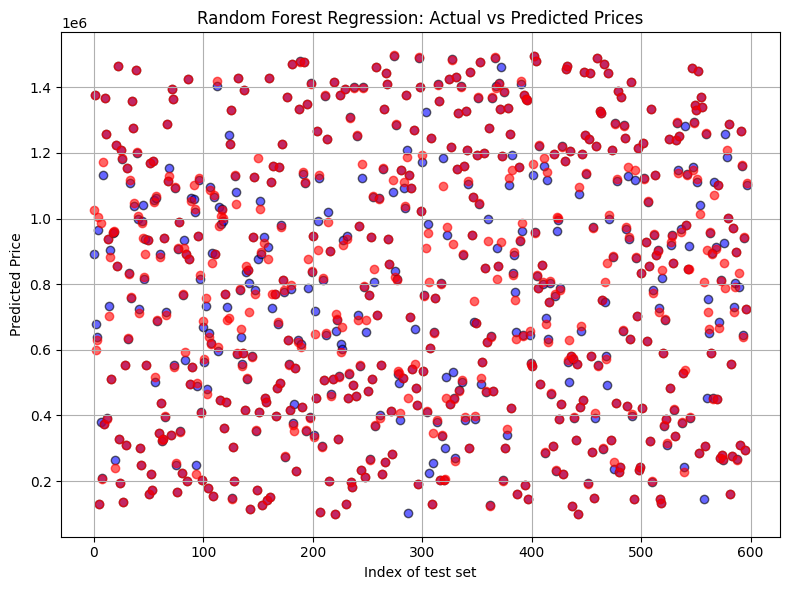

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test, alpha=0.6, color='blue', edgecolors='k')
plt.scatter(range(len(X_test)), y_pred, alpha=.6, color='red')
plt.xlabel('Index of test set')
plt.ylabel('Predicted Price')
plt.title('Random Forest Regression: Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from feast import FeatureStore
import pandas as pd

# Initialize store (repo_path points to the directory with feature_store.yaml)
store = FeatureStore(repo_path="experiment/.")

ModuleNotFoundError: No module named 'feast'

In [ ]:
entity_rows = [
    {"MLS_ID": 104635},   # Must match the join_keys in your Entity definition
    {"MLS_ID": 535721},
]

features = store.get_online_features(
    features=[
        "housing_features:Price",
        "housing_features:Bedrooms",
        "housing_features:Zipcode_encoded"
    ],
    entity_rows=entity_rows
).to_df()

features.head()

/opt/anaconda3/envs/deployml/lib/python3.11/site-packages/feast/utils.py:1253: UserWarning: Using entity name is deprecated. Use join_key instead.
  warnings.warn("Using entity name is deprecated. Use join_key instead.")


,MLS ID,Zipcode_encoded,Price,Bedrooms
0,104635,None,None,None
1,535721,None,None,None


In [ ]:
import sqlite3
import pandas as pd
con = sqlite3.connect("data/online_store.db")
print("\n--- Schema of online store ---")
print(
    pd.read_sql_query(
        "SELECT * FROM deployml2025_housing_features", con).columns.tolist())
con.close()


--- Schema of online store ---


DatabaseError: Execution failed on sql 'SELECT * FROM deployml2025_housing_features': no such table: deployml2025_housing_features

In [ ]:
from feast import FeatureStore

store = FeatureStore(repo_path="experiment")

features = store.get_online_features(
    features=[
        "housing_features:Price",
        "housing_features:Bedrooms"
    ],
    entity_rows=[{"MLS ID": 104635}]
).to_df()

print(features)

   MLS ID Price Bedrooms
0  104635  None     None


In [ ]:
parquet = pd.read_parquet('experiment/data/driver_stats.parquet')
parquet.dtypes

event_timestamp    datetime64[ns, UTC]
driver_id                        int64
conv_rate                      float32
acc_rate                       float32
avg_daily_trips                  int32
created                 datetime64[us]
dtype: object

In [ ]:
import pandas as pd

df = pd.read_parquet("experiment/data/house_data.parquet")

df.dtypes

Price                            int64
City                             int64
State                            int64
Bedrooms                         int64
Bathrooms                        int64
Area (Sqft)                      int64
Lot Size                         int64
Year Built                       int64
Days on Market                   int64
Property Type                    int64
Listing Agent                    int64
Status                           int64
Zipcode_encoded                float64
MLS ID                           int64
event_timestamp    datetime64[ns, UTC]
dtype: object

In [ ]:
parquet.dtypes

event_timestamp    datetime64[ns, UTC]
driver_id                        int64
conv_rate                      float32
acc_rate                       float32
avg_daily_trips                  int32
created                 datetime64[us]
dtype: object